In [2]:
import xarray as xr
import csv
import pandas as pd
import pickle
import numpy as np
import os
import datetime #import datetime, date, timedelta
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import os.path
import webbrowser
import time
from scipy.io import netcdf
import netCDF4
from datetime import date, timedelta, datetime
import globe
import warnings
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import matplotlib as mpl
warnings.filterwarnings("ignore")
from matplotlib.colors import LinearSegmentedColormap

from FUNCTIONS_HYCOM import set_regions, set_regions_offset

In [3]:
# define start and end years
# start_year = 2011 # 2009
# end_year = 2015 # 2018

# lat_max, lat_min, lon_max, lon_min for every region

regions = set_regions()

years = ['2011', '2012', '2013', '2014', '2015']
forcing_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/'

global_map_tag = True

In [4]:
def open_forcing(forcing_name, forcing_dir):
    df_forcing = pd.read_csv(forcing_dir + forcing_name)
    print(forcing_name)

    # Convert lon from [0,360] to [-180,180]
    df_forcing.lon = (df_forcing.lon + 180) % 360 - 180

    # Rename columns to match old version
    df_forcing.rename(columns={'lat': 'LAT', 'lon': 'LONG', 'wind_speed': \
                               'WIND', 'time': 'DATETIME', 'precipitation': 'PRECIPITATION'}, inplace=True)

#     # create mask based on start_year
#     dfs_mask_1 = pd.to_datetime(df_forcing.DATETIME).dt.year>=start_year
#     # apply mask start_year to df
#     dfs_1 = df_forcing[dfs_mask_1].reset_index()

#     # create mask based on end_year
#     dfs_mask_2 = pd.to_datetime(dfs_1.DATETIME).dt.year<=end_year
#     # apply mask end_year to df
#     dfs_select = dfs_1[dfs_mask_2].reset_index()
    df_forcing.shape
    df_forcing['DATETIME'] = pd.to_datetime(df_forcing['DATETIME'])
    df_forcing.to_pickle('dfs_select_forcing.pkl')
    return(df_forcing)

def draw_box(box_lims, ax):
    # box_lims = [lat_max, lat_min, lon_max, lon_min]
    ax.add_patch(patches.Rectangle((box_lims[3], box_lims[1]), box_lims[2]-box_lims[3], box_lims[0]-box_lims[1],\
                       fill = False,
                       color = "red",
                       linewidth = 1,
                       linestyle = '--'))

def create_event_box(events_all, region):
    # Select forcing data (hurricane strength) within box
    events_box = bfr_all[(events_all.LAT >= region[1]) & (events_all.LAT < region[0]) & \
                          (events_all.LONG >= region[3]) & (events_all.LONG < region[2])]

    # Keep lat/lons in the ocean only
    events_box = events_box.iloc[globe.is_ocean(events_box.LAT, events_box.LONG)]

    # Remove useless columns (old indexes..)
    events_box = events_box.iloc[:,1:]
    return(events_box.reset_index())

def map_events(long_event, lat_event, flag_plot='scatter'):
    fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
    ax = plt.axes(projection=ccrs.PlateCarree())
    map = Basemap(projection='cyl')
    map.drawmapboundary()
    map.fillcontinents(color='white')
    map.drawcoastlines()
    if flag_plot=='scatter':
        ax.scatter(long_event, lat_event, s = 0.01)
#     elif flag_plot=='hist':
        # add function with 2d histogram to show the number of events per bin
#     fig.tight_layout()
    return(ax)

def load_events(years_all, forcing_dir):
    # Make cumulative map
    bfr_all = open_forcing(forcing_name='df_forcing_' + years_all[0] + '.csv', forcing_dir=forcing_dir)

    for i in years_all[1:]:
        bfr_temp = open_forcing(forcing_name='df_forcing_' + i + '.csv', forcing_dir=forcing_dir)
        bfr_all = pd.concat([bfr_all,bfr_temp])
    return(bfr_all)

df_forcing_2011.csv
df_forcing_2012.csv
df_forcing_2013.csv
df_forcing_2014.csv
df_forcing_2015.csv


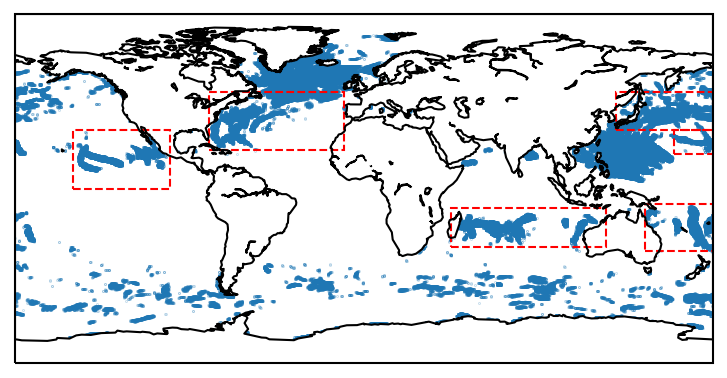

In [5]:
bfr_all = load_events(years_all=years, forcing_dir=forcing_dir).reset_index()

ax_map = map_events(long_event=bfr_all.LONG, lat_event=bfr_all.LAT)

for r in regions:
    draw_box(box_lims=r, ax=ax_map)

In [8]:
bfr_all

,index,Unnamed: 0,LAT,LONG,DATETIME,WIND,PRECIPITATION
0,0,0,59.386696,-44.386366,2011-01-01 00:00:00,33.531250,0.000004
1,1,0,59.386696,-44.181820,2011-01-01 00:00:00,34.593750,0.000011
2,2,0,59.386696,-43.977275,2011-01-01 00:00:00,35.430664,0.000027
3,3,0,59.386696,-43.772729,2011-01-01 00:00:00,36.028320,0.000064
4,4,0,59.386696,-43.568184,2011-01-01 00:00:00,36.015625,0.000122
...,...,...,...,...,...,...,...
1056260,304677,0,65.315142,-37.431820,2015-12-31 23:00:00,33.998047,0.000022
1056261,304678,0,65.315142,-37.227275,2015-12-31 23:00:00,34.091797,0.000024
1056262,304679,0,65.315142,-37.022729,2015-12-31 23:00:00,33.769530,0.000036
1056263,304680,0,65.519571,-37.022729,2015-12-31 23:00:00,33.014650,0.000001


In [ ]:
if global_map_tag:
    # GLOBAL MAP ONLY
    regions_global = [90, -90, 180, -180]
    region_global = regions_global
    

In [ ]:
if global_map_tag:
    events_box_global = bfr_all[(bfr_all.LAT >= region_global[1]) & (bfr_all.LAT < region_global[0]) & \
                         (bfr_all.LONG >= region_global[3]) & (bfr_all.LONG < region_global[2])]
    events_box_global = events_box_global.iloc[globe.is_ocean(events_box_global.LAT, events_box_global.LONG)]
    # Remove useless columns (old indexes..)
    events_box_global = events_box_global.iloc[:,1:].reset_index()
    events2select_global = create_event_box(events_all=bfr_all, region=region_global)
    
    

In [ ]:
if global_map_tag:
    # Keep the row with the max wind speed event
    # then remove all the other events within +- 7 days
    # find the second-max WS event and store it
    # remove all the other events within +- 7 days
    # and continue until no other events are left
    column_names = ['LAT','LONG','DATETIME','WIND','PRECIPITATION','ID']
    df_all_global = pd.DataFrame(columns = column_names)
    event_ID = 1 # ID for events

    radius_lat = 2 #deg
    radius_lon = 2 # deg

    while np.shape(events2select_global)[0] > 0:
        # Find event with max WS among those left
        event_sel_0 = events2select_global[events2select_global.WIND == events2select_global.WIND.max()].reset_index()
        event_sel = event_sel_0.iloc[0].to_frame().transpose()
        # Add event ID
        event_sel['ID'] = event_ID
        # Add event to final DataFrame
        df_all_global = pd.concat([df_all_global,event_sel])

        # Remove all rows within +- 7 days and within +- 2 deg lat/lon
        time_event = datetime(int(event_sel.DATETIME.dt.year), int(event_sel.DATETIME.dt.month), \
                              int(event_sel.DATETIME.dt.day), int(event_sel.DATETIME.dt.hour), \
                              int(event_sel.DATETIME.dt.minute), int(event_sel.DATETIME.dt.second)) 
        start_date = time_event + timedelta(days = - 7)
        end_date = time_event + timedelta(days = + 7)

        mask = ((pd.to_datetime(events2select_global['DATETIME']) > start_date) & (pd.to_datetime(events2select_global['DATETIME']) \
                                                                          < end_date) & (events2select_global['LAT'] < float(event_sel.LAT + radius_lat)) \
                & (events2select_global['LAT'] > float(event_sel.LAT - radius_lat)) & (events2select_global['LONG'] < float(event_sel.LONG + radius_lon)) \
                & (events2select_global['LONG'] > float(event_sel.LONG - radius_lon)))
        events2select_global = events2select_global.loc[~mask]

        # Increase event_ID
        event_ID = event_ID+1

    # Final result
    df_all_global = df_all_global.sort_values(by='DATETIME')

    print(len(df_all_global))


In [ ]:
if global_map_tag:
    # 2D histogram map of TOTAL NUMBER OF HURRICANE-STRENGTH WIND EVENTS IN HYCOM
    
    fig = plt.figure(figsize=(20, 6), dpi= 300, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=20))
    ax.stock_img()
    ax.coastlines(resolution='110m')
    x = np.squeeze(df_all_global.LONG)
    y = np.squeeze(df_all_global.LAT)

    # Discrete colormap
    #     cmap = plt.cm.viridis  # define the colormap
    #     cmap = plt.cm.hsv  # define the colormap
    # extract all colors from the colormap

#     colors = [(0, 0, 0), (161/255, 66/255, 195/255), (255/255, 153/255, 237/255), (0, 255/255, 255/255), \
#               (3/255, 174/255, 0), (244/255, 255/255, 2/255), (255/255, 135/255, 0), \
#               (1, 0, 0), (1, 1, 1)]  # R -> G -> B
#     # nero, arancione/grigio, 
#     n_bin = 45  # Discretizes the interpolation into bins
#     cmap_name = 'my_list'

#     cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)

#     # define the bins and normalize
#     # bounds = np.arange(0, 2000, 50) # hard coded - could not make it otherwise..
#     b0 = np.arange(0,200,10).ravel()
#     b1 = np.arange(200,500,50).ravel()
#     b2 = np.arange(510,3000,100).ravel()
#     # b3 = np.arange(2000,10000,2000).ravel()
#     bounds = np.concatenate((b0,b1,b2))
#     norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    colors = [(0, 0, 0), (161/255, 66/255, 195/255), (255/255, 153/255, 237/255), (0, 255/255, 255/255), \
              (3/255, 174/255, 0), (244/255, 255/255, 2/255), (255/255, 135/255, 0), \
              (1, 0, 0), (1, 1, 1)]  # R -> G -> B
    # nero, arancione/grigio, 
    n_bin = 15  # Discretizes the interpolation into bins
    cmap_name = 'my_list'
    
    cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
    
    # define the bins and normalize
#     bounds = np.linspace(.5, 9.5, 10) # hard coded - could not make it otherwise..
    bounds = np.linspace(.5, 14.5, 15)
    # hard coded - could not make it otherwise..
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    
    # Shift longitudes
    x_new = np.copy(x)
    x_new = x_new - 20

    h_count = plt.hist2d(x_new, y, bins=(np.arange(-180, 181, 1), np.arange(-90, 91, 1)), cmap=cmap, norm = norm, cmin = 1, vmin = 0, vmax = 5000) # add edges instead of bins
    print('max number per bin: ' + str(np.nanmax(h_count[0])))
    print('total number: ' + str(np.nansum(h_count[0])))

    ax.set_ylim(-70,90)
    # Add boxes
    regions = set_regions_offset(20)
    for r in regions:
        draw_box(box_lims=r, ax=ax)

    ax.text(0.01, 0.92, str(int(np.nansum(h_count[0]))) + ' hurricane-strength wind events', transform = ax.transAxes, fontsize=18, bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))
    cb = plt.colorbar(shrink = 1., pad = 0.02)
    plt.axvline(x=0 - 20, color='k',linewidth=0.8)
    plt.axhline(y=0, color='k',linewidth=0.8)
    cb.set_label('Number of events in bin', fontsize=18)
    cb.set_ticks(np.arange(0, 17, 1))
    cb.ax.set_xticklabels(np.arange(0, 17, 1))    
    cb.ax.tick_params(labelsize=12)
    #     plt.title('Map of events, ' + mask_tag + ' case', fontsize=12)
    plt.xlabel("Longitude ", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    fig.tight_layout() 



In [ ]:
y = np.squeeze(df_all_global.LAT)

plt.figure()
plt.hist(y, bins = 30)
plt.xlabel('Latitude [deg]', fontsize = 14)
plt.ylabel('Count [-]', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim([-90,90])
plt.tight_layout()
